# Projeto 01 - Car Price Prediction

### Objetivo
O objetivo é estimar um valor de venda para novos veículos.

O modelo será avaliado pelo R2 score.

### Base de dados
O conjunto de dados foi retirado do site CarDekho e a base contém 5.689 carros. 




Existem marcas de carros que ocorrem pouquíssimas vezes. Uma alternativa seria agrupar as marcas de carros menos frequentes para verificar se há melhora na métrica de acertos.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(202101)

## Análise dos dados

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
df_train = pd.read_csv("/content/drive/MyDrive/Aprendizado de Máquina/Bases/train_car_details.csv")

Os dados são compostos pelas variáveis:


* Variaveis quantitativas:<br>
 * Ano de fabricacao do carro (year)
 * Qtd de Km dirigidos (km_driven)
 * Potência máxima do motor (max_power)
 * Qtd de acentos (seats)
 * Quilometragem por litro (mileage)
 * Potencia do motor (engine)
 * Torque: responsável pela capacidade do motor produzir força motriz, ou seja, o movimento giratório
 * Preço de venda (selling_price) **Valor a ser predito**

* Variaveis qualitativas:
 * nome do carro (name)
 * tipo de combustivel utilizado (fuel)
 * tipo de vendendor (seller_type)
 * transmission: câmbio automático ou manual

 * Quantos donos ja possuiram o carro (owner)

### Análise de valores ausentes

In [73]:
df_train.head()
df_train.drop('Id', axis=1, inplace=True)

In [74]:
#Porcentagem de nan por atributo
print(round(100*df_train.isna().sum()/len(df_train), 2))

name             0.00
year             0.00
selling_price    0.00
km_driven        0.00
fuel             0.00
seller_type      0.00
transmission     0.00
owner            0.00
mileage          2.76
engine           2.76
max_power        2.65
torque           2.78
seats            2.76
dtype: float64


In [75]:
df_train[df_train['mileage'].isnull()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Hyundai Santro GLS I - Euro I,1999,80000,110000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
11,Fiat Punto 1.3 Emotion,2010,190000,120000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
37,Hyundai Santro Xing XG,2006,72000,110000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
48,Toyota Etios Liva GD,2012,400000,107500,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
92,Maruti Zen Estilo VXI BSIV W ABS,2011,170000,55113,Petrol,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5486,Hyundai Santro Xing XL eRLX Euro II,2006,105000,60000,Petrol,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN
5515,Maruti Omni LPG STD BSIV,1999,70000,100000,LPG,Individual,Manual,Fourth & Above Owner,NaN,NaN,NaN,NaN,NaN
5572,Hyundai Santro Xing XL,2007,90000,64000,Petrol,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
5611,Hyundai Santro GLS I - Euro II,2007,150000,60000,Petrol,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN


Pelo fatos dos NaN's estar majoritariamente presente nas mesmas linhas e por representar um baixo volume em relação ao total (menos de 3%), tais linhas serão retiradas.

In [76]:
print(f'Quantidade de linhas totais: ', df_train.shape[0])
# Remove as linhas com NaN
df_train = df_train.dropna(axis=0)   
print(f'Quantidade de linhas após retirada dos NaNs: ', df_train.shape[0])
#Aproximadamente 3% de linhas eliminadas
df_train = df_train.reset_index(drop=True)

Quantidade de linhas totais:  5689
Quantidade de linhas após retirada dos NaNs:  5531


## Pré-Processamento dos dados

Como observado, algumas variáveis possuem a unidade de medida associada. O objetivo é transformá-las em valores numéricos.

Mas antes, será verificado o comportamento das variáveis categóricas para identificar se será necessário algum tipo de tratamento.

In [77]:
print(df_train.fuel.unique())
print(df_train.seller_type.unique())
print(df_train.transmission.unique())
print(df_train.owner.unique())

['Diesel' 'Petrol' 'CNG' 'LPG']
['Individual' 'Dealer' 'Trustmark Dealer']
['Manual' 'Automatic']
['First Owner' 'Third Owner' 'Second Owner' 'Fourth & Above Owner'
 'Test Drive Car']


### Engine, max_power

In [78]:
df_train.engine.unique()

array(['1248 CC', '1995 CC', '2179 CC', '2982 CC', '796 CC', '1586 CC',
       '1197 CC', '2499 CC', '1498 CC', '1999 CC', '999 CC', '1582 CC',
       '2523 CC', '1595 CC', '1461 CC', '2494 CC', '1399 CC', '1599 CC',
       '998 CC', '1364 CC', '1193 CC', '1120 CC', '1373 CC', '1497 CC',
       '1194 CC', '1591 CC', '2696 CC', '1968 CC', '1198 CC', '1493 CC',
       '1405 CC', '1396 CC', '1969 CC', '799 CC', '1186 CC', '814 CC',
       '2956 CC', '1086 CC', '1199 CC', '936 CC', '2498 CC', '2489 CC',
       '1196 CC', '2143 CC', '1984 CC', '1368 CC', '993 CC', '1991 CC',
       '2967 CC', '1496 CC', '995 CC', '1598 CC', '1172 CC', '1495 CC',
       '1388 CC', '1499 CC', '1298 CC', '2487 CC', '2148 CC', '1994 CC',
       '2362 CC', '1061 CC', '2354 CC', '1596 CC', '2987 CC', '1998 CC',
       '1462 CC', '1339 CC', '1948 CC', '2953 CC', '624 CC', '3498 CC',
       '2200 CC', '1527 CC', '2755 CC', '1997 CC', '1794 CC', '1798 CC',
       '1047 CC', '1956 CC', '3604 CC', '2092 CC', '2993 CC'

In [79]:
df_train.max_power.unique()

array(['88.76 bhp', '187.74 bhp', '138.1 bhp', '171 bhp', '46.3 bhp',
       '104.68 bhp', '81.83 bhp', '72.4 bhp', '98.6 bhp', '177 bhp',
       '67 bhp', '126.2 bhp', '62.1 bhp', '102 bhp', '83.8 bhp',
       '88.5 bhp', '81.80 bhp', '68 bhp', '108.45 bhp', '103.2 bhp',
       '88.8 bhp', '67.1 bhp', '67.04 bhp', '138 bhp', '126.32 bhp',
       '47.3 bhp', '64.1 bhp', '71 bhp', '91.1 bhp', '67.05 bhp',
       '83.11 bhp', '74 bhp', '116.3 bhp', '94.68 bhp', '121.3 bhp',
       '162 bhp', '90 bhp', '108.5 bhp', '103.3 bhp', '70 bhp',
       '81.86 bhp', '91.72 bhp', '99 bhp', '120 bhp', '88.7 bhp',
       '80 bhp', '190 bhp', '100.57 bhp', '140 bhp', '53.3 bhp',
       '73.75 bhp', '98.96 bhp', '63.1 bhp', '73.97 bhp', '152.87 bhp',
       '55.2 bhp', '88.73 bhp', '58.16 bhp', '68.05 bhp', '77 bhp',
       '84 bhp', '56.3 bhp', '35 bhp', '83.1 bhp', '118.35 bhp',
       '112 bhp', '76 bhp', '75 bhp', '69 bhp', '93.7 bhp', '73 bhp',
       '105 bhp', '136 bhp', '100.6 bhp', '113.4 bhp'

Para qualquer valor de engine, temos a mesma unidade de medida e o mesmo ocorre com a variável max_power. Dessa forma, ficaremos apenas com os valores.

In [80]:
colunas = ['engine', 'max_power']

for i in colunas:
  df_train[i] = df_train[i].str.split(' ').str[0]

df_train['engine'] = pd.to_numeric(df_train['engine'])
df_train['max_power'] = pd.to_numeric(df_train['max_power'])

In [81]:
print("engine")
print(min(df_train["engine"]))
print(max(df_train["engine"]))

print("max_power")
print(min(df_train["max_power"]))
print(max(df_train["max_power"]))

engine
624
3604
max_power
34.2
280.0


### Mileage

In [82]:
df_train.mileage.unique()

array(['20.77 kmpl', '19.62 kmpl', '11.57 kmpl', '11.5 kmpl', '19.7 kmpl',
       '15.6 kmpl', '18.6 kmpl', '13.58 kmpl', '25.8 kmpl', '19.33 kmpl',
       '23.01 kmpl', '23.9 kmpl', '15.96 kmpl', '14.0 kmpl', '21.04 kmpl',
       '23.65 kmpl', '12.8 kmpl', '22.0 kmpl', '20.0 kmpl', '19.01 kmpl',
       '16.2 kmpl', '21.5 kmpl', '19.0 kmpl', '23.59 kmpl', '20.46 kmpl',
       '13.93 kmpl', '22.32 kmpl', '22.74 kmpl', '15.64 kmpl',
       '24.4 kmpl', '17.5 kmpl', '23.95 kmpl', '20.4 kmpl', '25.2 kmpl',
       '22.3 kmpl', '15.8 kmpl', '12.83 kmpl', '18.8 kmpl', '15.5 kmpl',
       '20.63 kmpl', '16.5 kmpl', '18.9 kmpl', '20.5 kmpl', '25.83 kmpl',
       '11.79 kmpl', '21.01 kmpl', '17.0 kmpl', '17.01 kmpl', '23.5 kmpl',
       '18.5 kmpl', '23.1 kmpl', '21.38 kmpl', '18.0 kmpl', '12.99 kmpl',
       '26.0 kmpl', '15.1 kmpl', '25.17 kmpl', '23.0 kmpl', '23.08 kmpl',
       '25.4 kmpl', '21.12 kmpl', '21.1 kmpl', '15.3 kmpl', '22.54 kmpl',
       '23.57 kmpl', '26.6 km/kg', '19.2 km/kg',

Temos km/L e Km/Kg.

In [83]:
for i in df_train.index:
  df_train.loc[i,"Unidade_fuel"]=df_train.loc[i,"mileage"].split()[1]

In [84]:
len(df_train.query('Unidade_fuel == "km/kg"'))

62

In [85]:
df_train.drop('Unidade_fuel', axis=1, inplace=True)

O tipo de combustível para os casos nos quais a unidade de medida é km/kg, são CNG (gás) e LPG (líquido), dessa forma, ao relizar a devida conversão para km/pl = km/L, pois é maioria no conjunto, os valores à gás ficariam muito pequenos. Dessa forma, optou-se por tranformar o tipo de combustível gasolina e diesel na unidade km/kg.

https://www.sciencedirect.com/topics/engineering/diesel-fuel

A densidade do diesel é de 0,85 kg/L, já a da gasolina, 0,74 kg/L.

Através da conversão de unidades, tem-se

$$
km/kg = \frac{km/L}{densidade} 
$$


https://unece.org/fileadmin/DAM/trans/main/wp29/wp29regs/2015/R115r1am1e.pdf

In [86]:
densidade_d = 0.85
densidadede_g = 0.74

for i in df_train.index:
  if df_train.loc[i, 'fuel'] == 'Diesel':
    df_train.loc[i,"mileage"] = round(float(df_train.loc[i,"mileage"].split()[0]) / densidade_d, 2)
  elif df_train.loc[i, 'fuel'] == 'Petrol':
    df_train.loc[i,"mileage"] = round(float(df_train.loc[i,"mileage"].split()[0]) / densidadede_g, 2)
  else:
    df_train.loc[i,"mileage"] =  round(float(df_train.loc[i,"mileage"].split()[0]), 2)

In [87]:
df_train['mileage'] = pd.to_numeric(df_train['mileage'])
print(min(df_train["mileage"]))
print(max(df_train["mileage"]))

0.0
35.14


In [88]:
df_train.query('mileage == 0')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
425,Hyundai Santro Xing (Non-AC),2010,110000,80000,Petrol,Individual,Manual,Second Owner,0.0,1086,62.10,96.1Nm@ 3000rpm,5.0
471,Land Rover Freelander 2 TD4 HSE,2013,1650000,64788,Diesel,Dealer,Automatic,First Owner,0.0,2179,115.00,400 Nm /2000 rpm,5.0
2369,Hyundai Santro Xing (Non-AC),2010,110000,80000,Petrol,Individual,Manual,Second Owner,0.0,1086,62.10,96.1Nm@ 3000rpm,5.0
2492,Volkswagen Polo GT TSI BSIV,2014,574000,28080,Petrol,Dealer,Automatic,First Owner,0.0,1197,103.25,175nm@ 1500-4100rpm,5.0
2499,Hyundai Santro Xing GL,2008,105000,128000,Petrol,Individual,Manual,First Owner,0.0,1086,62.00,96.1Nm@ 3000rpm,5.0
3268,Hyundai Santro Xing GL,2011,150000,40000,Petrol,Individual,Manual,Fourth & Above Owner,0.0,1086,62.00,96.1Nm@ 3000rpm,5.0
3315,Mahindra Bolero Pik-Up CBC 1.7T,2019,722000,80000,Diesel,Individual,Manual,First Owner,0.0,2523,70.00,200Nm@ 1400-2200rpm,2.0
3424,Hyundai Santro Xing (Non-AC),2013,184000,15000,Petrol,Individual,Manual,First Owner,0.0,1086,62.10,96.1Nm@ 3000rpm,5.0
3808,Mercedes-Benz M-Class ML 350 4Matic,2011,1700000,110000,Diesel,Individual,Automatic,Third Owner,0.0,2987,165.00,510@ 1600-2400,5.0
4523,Mercedes-Benz GLC 220d 4MATIC,2017,3300000,60000,Diesel,Dealer,Automatic,First Owner,0.0,1950,194.00,400nm@ 2800rpm,5.0


Valores zeros para mileage serão substituídos por NaN para posterior input de valores.

In [89]:
df_train.mileage.replace(0, np.nan, inplace=True)

### Torque

Realizar a limpeza do torque será desafiador, uma vez que há diferentes unidades, bem como, diferentes tipos de 'escritas'.

In [90]:
df_train.torque.unique()

array(['200Nm@ 1750rpm', '400Nm@ 1750-2500rpm', '320Nm@ 1700-2700rpm',
       '343Nm@ 1400-3400rpm', '62Nm@ 3000rpm', '145@ 4,100(kgm@ rpm)',
       '114.7Nm@ 4000rpm', '171Nm@ 1800rpm', '430Nm@ 1750-2500rpm',
       '91Nm@ 4250rpm', '259.9Nm@ 1900-2750rpm', '195Nm@ 1400-2200rpm',
       '15@ 3,800(kgm@ rpm)', '200Nm@ 1900rpm',
       '20.4@ 1400-3400(kgm@ rpm)', '113Nm@ 4200rpm', '160Nm@ 2000rpm',
       '248Nm@ 2250rpm', '14.9 KGM at 3000 RPM', '90Nm@ 3500rpm',
       '170Nm@ 1800-2400rpm', '259.8Nm@ 1900-2750rpm', '69Nm@ 3500rpm',
       '100Nm@ 2700rpm', '180.4Nm@ 1750-2500rpm', '130Nm@ 4000rpm',
       '190Nm@ 2000rpm', '146Nm@ 4800rpm', '120Nm@ 4250rpm',
       '190Nm@ 1750-3000rpm', '151Nm@ 4850rpm', '340Nm@ 1800-3250rpm',
       '200Nm@ 1750-3000rpm', '250Nm@ 1500-2500rpm', '145Nm@ 4100rpm',
       '104Nm@ 4000rpm', '113.75nm@ 4000rpm', '209Nm@ 2000rpm',
       '215Nm@ 1750-3000rpm', '290Nm@ 1800-2800rpm',
       '13.5@ 2,500(kgm@ rpm)', '154.9Nm@ 4200rpm', '204Nm@ 2000-2750rpm

Diante dos valores únicos, optou-se por criar duas variáveis para torque: uma que traz o valor em Nm e o outro, em rpm.

A tratativa será realizada por partes.

In [91]:
df_train['torque'] = df_train['torque'].str.replace(',', '', regex=True).replace('at', '', regex=True)

In [92]:
df_train['torque_Nm'] = df_train.torque.str.split(' ', expand=True)[0].str.extract(r'(^([0-9]*[-])?[0-9]+)')[0]
df_train['torque_rpm'] = df_train.torque.str.split(' ', expand=True)[1].str.extract(r'(^([0-9]*[-])?[0-9]+)')[0]
df_train['torque_rpm'].values[df_train['torque_rpm'].values == '175-2750'] = '1750-2750'
#selecionando o primeiro valor dos casos com traço: '1750-2750'
df_train['torque_rpm'] = df_train.torque_rpm.str.split('-', expand=True)[0]

In [93]:
df_train['torque_rpm'] = pd.to_numeric(df_train['torque_rpm'])
df_train['torque_Nm'] = pd.to_numeric(df_train['torque_Nm'])
#eliminando a coluna torque
df_train.drop('torque', axis=1, inplace=True)

Análise de valores discrepantes

In [94]:
df_train.describe()

,year,selling_price,km_driven,mileage,engine,max_power,seats,torque_Nm,torque_rpm
count,5531.000000,5.531000e+03,5.531000e+03,5520.000000,5531.000000,5531.000000,5531.000000,5531.000000,5342.000000
mean,2013.920810,6.396651e+05,6.926906e+04,24.315493,1458.589405,91.242470,5.422528,167.454891,2703.949832
std,3.873994,7.858599e+05,5.139751e+04,4.923319,504.526402,35.127503,0.960857,97.118715,1114.845504
min,1994.000000,2.999900e+04,1.000000e+00,11.760000,624.000000,34.200000,2.000000,4.000000,1000.000000
25%,2012.000000,2.650000e+05,3.500000e+04,20.940000,1197.000000,68.050000,5.000000,99.500000,1750.000000
50%,2015.000000,4.500000e+05,6.000000e+04,25.000000,1248.000000,82.000000,5.000000,154.000000,2000.000000
75%,2017.000000,6.750000e+05,9.575000e+04,27.730000,1582.000000,102.000000,5.000000,202.000000,4000.000000
max,2020.000000,7.200000e+06,1.500000e+06,35.140000,3604.000000,280.000000,10.000000,789.000000,5000.000000


Como o valor mínimo do torque é 4, realizando algumas buscas no google, identificamos que um valor de torque mínimo aceitável é 28 e chegou-se nesse resultado consultando algumas marcas de carro do nosso banco no google e foi identificado que quando o torque era 28 para alguma marca de carro, o resultado batia. Dessa forma, vamos atribuir NaN para valores de torque menores que 28.

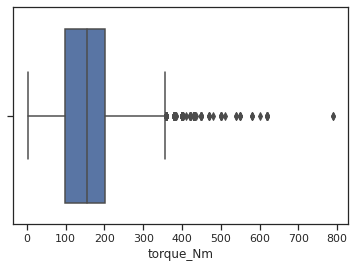

In [95]:
ax = sns.boxplot(x="torque_Nm", data=df_train)

Pelo gráfico do boxplot pode-se observar que há valores com torque muito alto, dessa forma, será atribuido NaN para esses valores também.

In [96]:
len(df_train.query('torque_Nm < 28'))

340

In [97]:
df_train.query('torque_Nm > 700')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_Nm,torque_rpm
507,Maruti Zen D,2003,85000,120000,Diesel,Individual,Manual,Third Owner,24.47,1527,58.0,5.0,789,2250.0
1245,Maruti Zen D,2002,120000,60000,Diesel,Individual,Manual,Second Owner,24.47,1527,58.0,5.0,789,2250.0


In [98]:
df_train['torque_Nm'].values[df_train['torque_Nm'].values < 28] = 0
df_train['torque_Nm'].values[df_train['torque_Nm'].values > 700] = 0
df_train.torque_Nm.replace(0, np.nan, inplace=True)

In [99]:
len(df_train[df_train['torque_Nm'].isnull()])

342

O mesmo para km_driven

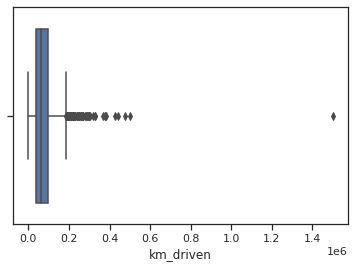

In [100]:
ax = sns.boxplot(x="km_driven", data=df_train)

In [101]:
df_train.query('km_driven >= 1500000')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_Nm,torque_rpm
3990,Mahindra XUV500 W6 2WD,2012,500000,1500000,Diesel,Individual,Manual,First Owner,17.76,2179,140.0,7.0,330.0,1600.0


In [102]:
df_train['km_driven'].values[df_train['km_driven'].values >= 1500000] = 0
df_train.km_driven.replace(0, np.nan, inplace=True)

### Name - Marca do carro

A variável marca do carro será criada

In [103]:
#Criando a coluna marca
df_train['brand'] = df_train['name'].str.split(' ').str[0]
df_train.drop('name', axis = 1, inplace = True)

### Preenchendo valores ausentes com o KNN imputer

In [104]:
#retirando a variavel alvo na hora de sar o knn imputer
X = df_train

col_valor = []
col_categoria = []

for i in X.columns:
  if df_train[i].dtype == 'object':
    col_categoria.append(i)
  else:
    col_valor.append(i)

In [105]:
X_final = X[col_valor]
# knn imputation treino
from numpy import isnan
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X_final)
# transform the dataset
Xtrans = imputer.transform(X_final)

In [106]:
base_categoria = pd.DataFrame()
base_categoria = df_train[col_categoria]
base_valor = pd.DataFrame(Xtrans, columns=X_final.columns)

In [107]:
#Juntando bases apos imputacao
df_final = pd.concat([base_valor, base_categoria], axis=1)

In [108]:
#Porcentagem de nan por atributo
print(round(100*df_final.isna().sum()/len(df_train), 2))


year             0.0
selling_price    0.0
km_driven        0.0
mileage          0.0
engine           0.0
max_power        0.0
seats            0.0
torque_Nm        0.0
torque_rpm       0.0
fuel             0.0
seller_type      0.0
transmission     0.0
owner            0.0
brand            0.0
dtype: float64


In [109]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531 entries, 0 to 5530
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           5531 non-null   float64
 1   selling_price  5531 non-null   float64
 2   km_driven      5531 non-null   float64
 3   mileage        5531 non-null   float64
 4   engine         5531 non-null   float64
 5   max_power      5531 non-null   float64
 6   seats          5531 non-null   float64
 7   torque_Nm      5531 non-null   float64
 8   torque_rpm     5531 non-null   float64
 9   fuel           5531 non-null   object 
 10  seller_type    5531 non-null   object 
 11  transmission   5531 non-null   object 
 12  owner          5531 non-null   object 
 13  brand          5531 non-null   object 
dtypes: float64(9), object(5)
memory usage: 605.1+ KB


### Análise descritiva

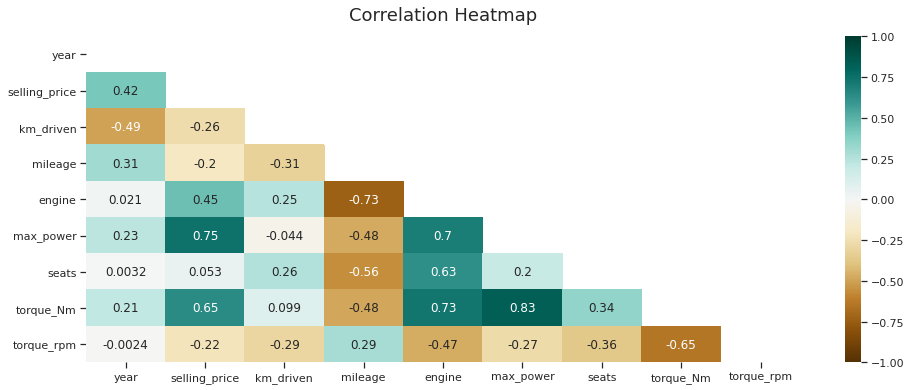

In [110]:
#correlacao de Pearson
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_final.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_final.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Através da correlação de Pearson entre as variáveis é possível observar que o preço é altamente correlacionado com max_power e o torque_Nm. Também nota-se que as variáveis torque_Nm e max_power são altamente correlacionadas. 

Como a correlação de Pearson é realizada entre duas variáveis, as variáveis que são correlacionadas com o preço e correlacionas entre si, serão mantidas.

A análise dos outliers foram realizadas durante a tratativa de cada variável, mas segue o gráfico de boxplot de todas as variáveis para verificar o comportamento, bem como, a distribuição de cada.

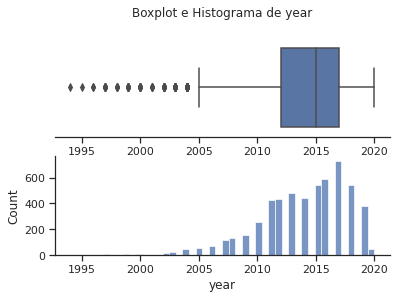

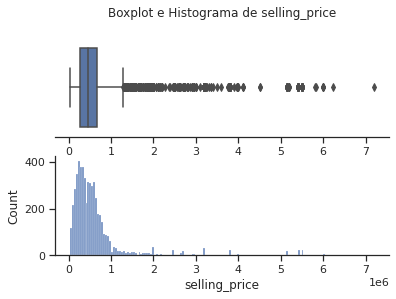

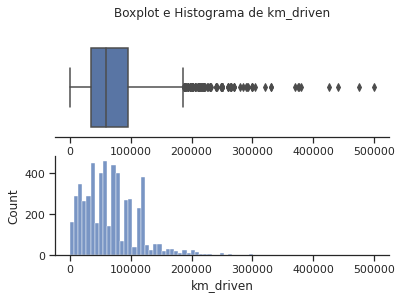

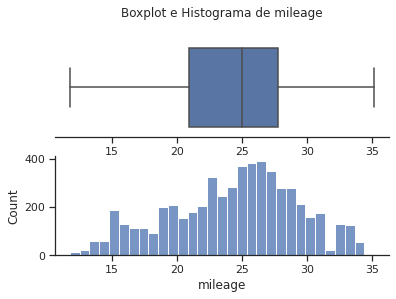

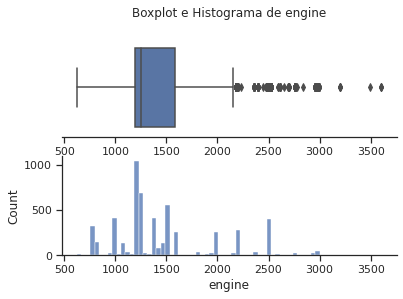

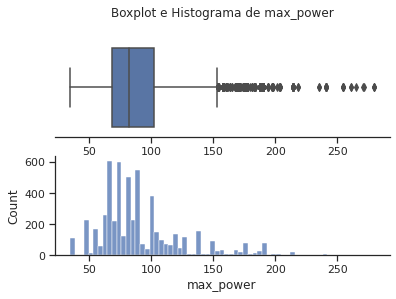

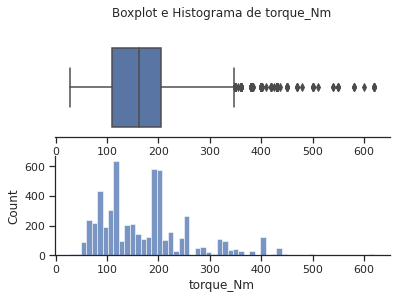

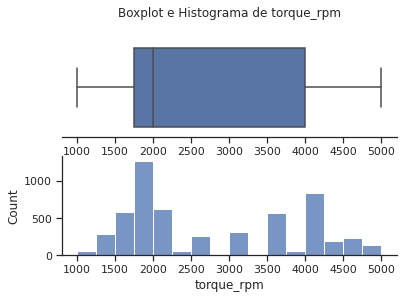

In [111]:
vars_num = ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque_Nm', 'torque_rpm']

for i in vars_num:

  sns.set(style="ticks")

  x = df_final[i]
  coluna = i

  f, (ax_box, ax_hist) = plt.subplots(2)

  sns.boxplot(x=x, ax=ax_box)
  sns.histplot(x=x, ax=ax_hist)

  ax_box.set(yticks=[])
  sns.despine(ax=ax_hist)
  sns.despine(ax=ax_box, left=True)
  ax_box.set_title('Boxplot e Histograma de {}\n'.format(coluna))

plt.show()

Variáveis categóricas

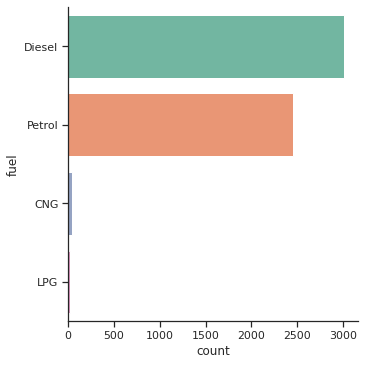

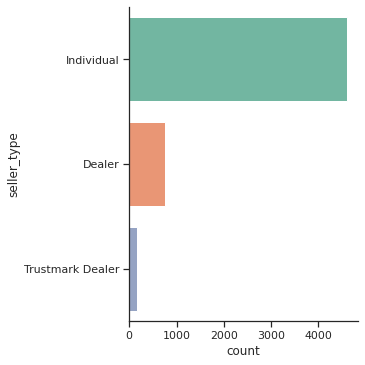

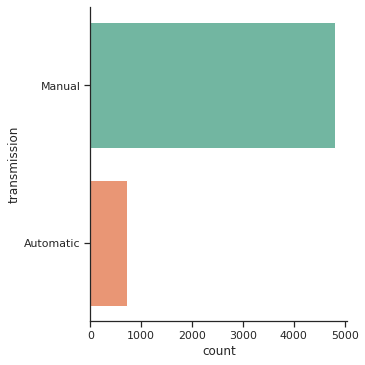

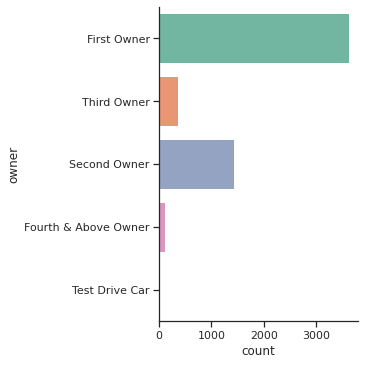

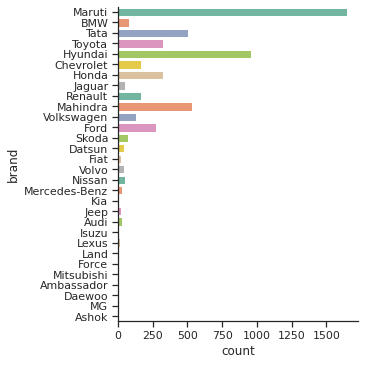

In [112]:
for i in df_final.select_dtypes(include=['object']).columns.values:

  sns.set(style="ticks")

  x = df_final[i]
  coluna = i

  sns.catplot(y=x, kind="count", palette="Set2", data=df_final); 

plt.show()

Tranformação das variáveis categóricas em variáveis binárias

In [113]:
df_final = pd.get_dummies(df_final)

## Modelagem

In [114]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold

In [115]:
#retirando a variavel alvo da base de teste
treino = df_final.drop(columns='selling_price')
y = df_final.selling_price.values
X = treino

Divisão da base de treino e da base de teste

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 202102)

In [117]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

## Random Forest Regressor

O algoritmo da Floresta Aleatória é um conjunto de árvores de decisão construídas de maneira aleatória, como o próprio nome já diz, e o benefício é que a previsão média dos estimadores das árvores melhora a precisão.

In [118]:
%%time
RFreg = RandomForestRegressor(random_state=2021)

RFreg.fit(X_train, y_train)
print("R2 score do treino:",r2_score(y_train, RFreg.predict(X_train)))
print("R2 score da validação:",r2_score(y_test, RFreg.predict(X_test)))

R2 score do treino: 0.9953311750116849
R2 score do teste: 0.9741845816893564
CPU times: user 2.57 s, sys: 18 ms, total: 2.59 s
Wall time: 2.6 s


O R2 Score do treino foi muito bom utilizando árvores. A ideia é melhorar os hiperparâmetros para evitar o overfitting, e para isso, será utilizado o modelo LGBMRegressor.

In [119]:
LGBM = LGBMRegressor(random_state=17)

In [127]:
LGBM.fit(X_train, y_train)
print("R2 score treino:",r2_score(y_train, LGBM.predict(X_train)))
print("R2 score validação:",r2_score(y_test, LGBM.predict(X_test)))

R2 score treino: 0.9876706538387983
R2 score validação: 0.9746035583159949


In [121]:
from sklearn.model_selection import GridSearchCV

#outro parametros interessante para evitar overfitting eh max_depth,
#mas para evitar mais tempo de processamento, optou-se por retira-lo.

param_grid = {'num_leaves': [3, 15, 31, 60, 100, 120], 
              'learning_rate': np.logspace(-3, 0, 10)
              }

grid_searcher_LGBM = GridSearchCV(estimator=LGBM, param_grid=param_grid, scoring=('r2'),
                             cv=10, verbose=0, n_jobs=2)

In [122]:
grid_searcher_LGBM.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   34.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 600 out of 600 | elapsed:  1.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=17,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=2,
             param_grid={'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
      

In [123]:
grid_searcher_LGBM.best_params_, grid_searcher_LGBM.best_score_

({'learning_rate': 0.21544346900318823, 'num_leaves': 100}, 0.9689347735700945)

In [124]:
r2_score(y_test, grid_searcher_LGBM.predict(X_test))

0.9751034656517276

In [125]:
final_LGBM = LGBMRegressor(num_leaves=grid_searcher_LGBM.best_params_['num_leaves'],
                           learning_rate=grid_searcher_LGBM.best_params_['learning_rate'],
                           n_jobs=2)

In [129]:
scores = cross_validate(final_LGBM, X_train, y_train, cv=10,
                         scoring=('r2','neg_mean_squared_error'),
                         return_train_score=True)

print('R2 score do treino: {} +- {}'.format(scores['train_r2'].mean(),scores['train_r2'].std()))
print('R2 score do teste: {} +- {}'.format(scores['test_r2'].mean(),scores['test_r2'].std()))

R2 score do treino: 0.9955132234726951 +- 0.0004748606484796759
R2 score do teste: 0.9689347735700945 +- 0.010824231686371777


In [130]:
final_LGBM.fit(X_train, y_train)
print('R2 score da validação:{}'.format(r2_score(y_test, final_LGBM.predict(X_test))))

R2 score da validação:0.9751034656517276


In [131]:
final_LGBM.fit(treino,y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.21544346900318823,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=2, num_leaves=100,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [132]:
print(r2_score(y, final_LGBM.predict(treino)))

0.9953215140505249
